# How does the word-frequency of my Anki cards change with time?

Over the past year I have been learning French using the [**Refold**](https://refold.la/) method which incorporates a practice known as [*Sentence Mining*](https://refold.la/roadmap/stage-2/a/basic-sentence-mining). Sentence Mining is the practice of learning vocabulary in your target language from sentences you find in the wild, such as from books or subtitles. Specifically, you 'mine' every sentence encountered where you know every word in the sentence except exactly one of them - these are known as 1-target (1T) sentences. Once you have gathered a bunch of these sentences, you then make flashcards out of them. On the front of each card is the sentence you mined and on the back is the definition or translation of the one word that you didn't know when you first read the sentence. You can then review these cards to grow your vocabulary in the language that you're learning. The digital flashcard system that I and many others use is known as [Anki](https://apps.ankiweb.net/).

One of the logical consequences of sentence mining is that as you grow your vocabulary, sentences that would've previously been 2T, 3T, NT become 1T and also that the words you learn become rarer and rarer. You start of by learning words that are used all the time in the target language like 'door' (*porte*) to learning words that are used very infrequently like 'platypus' (*ornithorynque*). Over the past year, I have heard from many people in the community state that the vocabulary that they learn when using Anki becomes rarer and rarer over time. I have also felt this to be my experience, but I thought I would test this assumption with data rather than just rely on anectodal evidence.

In this analysis, I will be working with Anki's SQLite database stored locally on my computer containing each of my 2,815 cards that I've made myself over the past year. I will also be using the frequency-list of French words provided by [Lexique](http://www.lexique.org/). A frequency list is a database that contains a list of words in a language and gives them a score based on how often they're used (spoken/written). Specifically I will be measuring the 'rareness' of my vocab cards based on the frequency lists' non-lemmatized, book frequency (the frequency list will distinguish words like 'es' and 'est' to be different and the frequency score is determined based on how often the words appear in books). Words that are used often have high frequency scores and words that are not used often (rare) have low frequency scores.

---

## Technical preamble (feel free to skip)

*Before we begin, I would just like to add there is more that could be added to this analysis to make the results a bit more accurate and less approximative. I decided to simplify the analysis for myself by using the frequency lists' non-lemmatized scores rather than its' lemmatized scores. It's debatable whether this would be the right decision because in French, if you can understand one form of the word, you can almost always understand every other form of the word (to someone familiar with French, the word 'pensassions' is obviously just another form of the word 'penser'). I also could have found a way to incorporate the frequency scores based on vocabulary used in French films because some of my sentences have actually come from films even though most have been from books. Next, instead of searching for the 1T word in each of my cards, I just searched for the rarest word used in the card. 99% of the time the rarest word used in the card will in fact be the 1T word and so this will likely not bias the analysis in any significant way. The reason I chose this approach over specifically extracting the 1T word from each card was to save time and simplify the text-mining required to carry out the analysis (this was just meant to be a short, fun analysis after all!). Finally, I carry out two non-parametric correlation tests at the end of the analysis to determine whether or not there is a relation between the rareness of my vocabulary cards and the number of cards made. Once more, this was to save time and simplify the analysis since if I were test for linear correlation, there would be much more work involved due to the likely non-linear relationship between the two variables.*

---

In [1]:
#Set Random Seed
set.seed(42)

## Libraries

In [2]:
#For the Anki database
library(RSQLite)
library(DBI)
library(jsonlite)

library(tidyverse)

#Text-processing
library(quanteda)

#To apply certain operations in parallel
library(parallel)

#For date-time objects
library(lubridate)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──
✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.1.2     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter()  masks stats::filter()
✖ purrr::flatten() masks jsonlite::flatten()
✖ dplyr::lag()     masks stats::lag()
Package version: 1.4.3
Parallel computing: 2 of 4 threads used.
See https://quanteda.io for tutorials and examples.

Attaching package: ‘quanteda’

The following object is masked from ‘jupyter:irkernel’:

    View

The following object is masked from ‘package:utils’:

    View


Attaching package: ‘lubridate’

The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union



## Access the Anki Database

In [3]:
connection <- dbConnect(SQLite(), dbname="collection.anki2")

### Load the notes table

The `notes` table contains the data for all of my flashcards, specifically the sentences used on the front of each card.

In [4]:
result <- dbSendQuery(connection, "SELECT * from notes")
notes_data <- dbFetch(result)
dbClearResult(result)

In [5]:
#disconnect from the database
dbDisconnect(connection)

---

## Load the frequency list

In [6]:
#load the French frequency list
freq_list <- read.csv(file = 'Lexique383.tsv', sep = '\t', header = TRUE, stringsAsFactors = FALSE)

In [7]:
#convert to tibble
freq_list <- as_tibble(freq_list)

In [8]:
head(freq_list)

ortho,phon,lemme,cgram,genre,nombre,freqlemfilms2,freqlemlivres,freqfilms2,freqlivres,...,orthrenv,phonrenv,orthosyll,cgramortho,deflem,defobs,old20,pld20,morphoder,nbmorph
a,a,a,NOM,m,,81.36,58.65,81.36,58.65,...,a,a,a,"NOM,AUX,VER",NA,NA,1.00,1.00,a,1
a,a,avoir,AUX,,,18559.22,12800.81,6350.91,2926.69,...,a,a,a,"NOM,AUX,VER",NA,NA,1.00,1.00,avoir,1
a,a,avoir,VER,,,13572.40,6426.49,5498.34,1669.39,...,a,a,a,"NOM,AUX,VER",93,16,1.00,1.00,avoir,1
a capella,akapEla,a capella,ADV,,,0.04,0.07,0.04,0.07,...,allepac a,alEpaka,a ca-pel-la,ADV,NA,NA,3.85,2.85,a-capella,2
a cappella,akapEla,a cappella,ADV,,,0.04,0.07,0.04,0.07,...,alleppac a,alEpaka,a cap-pel-la,ADV,NA,NA,4.60,2.85,a-cappella,2
a contrario,ak§tRaRjo,a contrario,ADV,,,0.00,0.27,0.00,0.27,...,oirartnoc a,ojRaRt§ka,a con-tra-rio,ADV,NA,NA,4.30,3.30,a-contrario,2


In [9]:
#bit of French-English translation
#we base the frequency off of the frequency used in books
freq_list <- rename(freq_list, word=ortho, frequency=freqlivres)

In [10]:
head(freq_list)

word,phon,lemme,cgram,genre,nombre,freqlemfilms2,freqlemlivres,freqfilms2,frequency,...,orthrenv,phonrenv,orthosyll,cgramortho,deflem,defobs,old20,pld20,morphoder,nbmorph
a,a,a,NOM,m,,81.36,58.65,81.36,58.65,...,a,a,a,"NOM,AUX,VER",NA,NA,1.00,1.00,a,1
a,a,avoir,AUX,,,18559.22,12800.81,6350.91,2926.69,...,a,a,a,"NOM,AUX,VER",NA,NA,1.00,1.00,avoir,1
a,a,avoir,VER,,,13572.40,6426.49,5498.34,1669.39,...,a,a,a,"NOM,AUX,VER",93,16,1.00,1.00,avoir,1
a capella,akapEla,a capella,ADV,,,0.04,0.07,0.04,0.07,...,allepac a,alEpaka,a ca-pel-la,ADV,NA,NA,3.85,2.85,a-capella,2
a cappella,akapEla,a cappella,ADV,,,0.04,0.07,0.04,0.07,...,alleppac a,alEpaka,a cap-pel-la,ADV,NA,NA,4.60,2.85,a-cappella,2
a contrario,ak§tRaRjo,a contrario,ADV,,,0.00,0.27,0.00,0.27,...,oirartnoc a,ojRaRt§ka,a con-tra-rio,ADV,NA,NA,4.30,3.30,a-contrario,2


In [11]:
#order the frequency list by frequency to see the most common French words first
freq_list <- arrange(freq_list, desc(frequency))

In [12]:
head(freq_list)

word,phon,lemme,cgram,genre,nombre,freqlemfilms2,freqlemlivres,freqfilms2,frequency,...,orthrenv,phonrenv,orthosyll,cgramortho,deflem,defobs,old20,pld20,morphoder,nbmorph
de,d°,de,PRE,,,25220.86,38928.92,25220.86,38928.92,...,ed,°d,de,"ART:def,PRE",NA,NA,1.00,NA,de,1
la,la,la,ART:def,f,s,14946.48,23633.92,14946.48,23633.92,...,al,al,la,"ART:def,NOM,PRO:per",NA,NA,1.00,1,la-:def,2
et,e,et,CON,,,12909.08,20879.73,12909.08,20879.73,...,te,e,et,CON,NA,NA,1.05,1,et,1
à,a,à,PRE,,,12190.40,19209.05,12190.40,19209.05,...,à,a,à,PRE,NA,NA,1.00,1,à,1
le,l°,le,ART:def,m,s,13652.76,18310.95,13652.76,18310.95,...,el,°l,le,"ART:def,PRO:per",NA,NA,1.00,NA,le-:def,2
il,il,il,PRO:per,m,s,13222.93,15832.09,13222.93,15832.09,...,li,li,il,"ADJ:num,ADV,PRO:per",NA,NA,1.30,1,il-:per,2


Since the `word` column is not a primary key, it is not a unique identifier and therefore we will remove duplicates to simplify our analysis.

In [13]:
#clean up the table to remove duplicate w
freq_list <- freq_list[!duplicated(freq_list$word),]

---

## Clean the notes anki data

In [14]:
tail(notes_data)

,id,guid,mid,mod,usn,tags,flds,sfld,csum,flags,data
2810,1628552651439,AWcz!<0]S#,1589851515791,1628552651,1095,,"<span style=""color: rgb(255, 0, 0);"">Un agencement.&nbsp;</span><div><b><span style=""font-weight: 400;"">Pendant que les rongeurs assimilent l’agencement de l’espace, les chercheurs enregistrent le schéma d’activité de leurs cellules cérébrales.</span></b></div><div>[sound:googletts-51463cf6-9b193f82-04d593a0-068a080a-1672fd8b.mp3]<br></div> <font color=""#ff0000"">Un agencement. </font>Manière d'arranger, de mettre en ordre. Ainsi l'on pourrait dire, l'agencement de mes livres, l'agencement d'un magasin, d'une boutique, d'un cabinet, d'une chambre","Un agencement.&nbsp;Pendant que les rongeurs assimilent l’agencement de l’espace, les chercheurs enregistrent le schéma d’activité de leurs cellules cérébrales.[sound:googletts-51463cf6-9b193f82-04d593a0-068a080a-1672fd8b.mp3]",1382964953,0,
2811,1628552726905,P9q!Ka/BAD,1589851515791,1628552726,1095,,"<span style=""color: rgb(255, 0, 0);"">Onirique.&nbsp;</span><div><b><span style=""font-weight: 400;"">Ce ralentissement spectaculaire du temps neuronal est peut-être la raison pour laquelle notre vie onirique nous semble bien plus longue que ce que nous assure notre réveil.</span></b></div><div>[sound:googletts-7ab0d371-f69169cf-4264e3ed-6e32b9e8-6a9e4f4a.mp3]<br></div> <font color=""#ff0000"">Onirique. </font>Relatif au rêve.",Onirique.&nbsp;Ce ralentissement spectaculaire du temps neuronal est peut-être la raison pour laquelle notre vie onirique nous semble bien plus longue que ce que nous assure notre réveil.[sound:googletts-7ab0d371-f69169cf-4264e3ed-6e32b9e8-6a9e4f4a.mp3],81107675,0,
2812,1628552978797,k?(F@!e`[-,1589851515791,1628552978,1095,,"<b><span style=""font-weight: 400;""><font color=""#ff0000"">Entériner.&nbsp;</font></span></b><div><b><span style=""font-weight: 400;"">Par son scepticisme tout professoral, son mentor, Kleitman, souhaite voir se répéter ces résultats avant de les entériner.</span></b></div><div>[sound:googletts-99d6d311-170dac3e-17e1dcaf-3ac6f1ce-9bc60809.mp3]<br></div> <b><span style=""font-weight: 400;""><font color=""#ff0000"">Entériner.&nbsp;</font></span></b>Rendre définitif, valide en l'approuvant.","Entériner.&nbsp;Par son scepticisme tout professoral, son mentor, Kleitman, souhaite voir se répéter ces résultats avant de les entériner.[sound:googletts-99d6d311-170dac3e-17e1dcaf-3ac6f1ce-9bc60809.mp3]",3656442034,0,
2813,1628553460470,E;f-B|Og7o,1589851515791,1628553460,1095,,"<span style=""color: rgb(255, 0, 0);"">Prévaloir.&nbsp;&nbsp;</span><div><b><span style=""font-weight: 400;"">Par contraste, l’étape de rêve du sommeil REM qui prévaut plus tard dans la nuit, joue un rôle dans le renforcement de ces connexions.</span></b></div><div>[sound:googletts-b5bd7aaa-14941976-8fb84fb8-f5e72322-f286872a.mp3]<br></div> <font color=""#ff0000"">Prévaloir.&nbsp;&nbsp;</font><a href=""https://www.linternaute.fr/dictionnaire/fr/definition/dominer/"">dominer</a>,&nbsp;<a href=""https://www.linternaute.fr/dictionnaire/fr/definition/triompher/"">triompher</a>","Prévaloir.&nbsp;&nbsp;Par contraste, l’étape de rêve du sommeil REM qui prévaut plus tard dans la nuit, joue un rôle dans le renforcement de ces connexions.[sound:googletts-b5bd7aaa-14941976-8fb84fb8-f5e72322-f286872a.mp3]",4215010434,0,
2814,1628553560389,wf(>1gl2CI,1589851515791,1628553560,1095,,"<span style=""color: rgb(255, 0, 0);"">Un tambour.&nbsp;</span><div>[sound:googletts-35d6bf7f-e317e219-4b09f882-8b2f5472-a5894e08.mp3]<span style=""color: rgb(255, 0, 0);""><br></span></div> <font color=""#ff0000"">Un tambour.&nbsp;</font><img src=""M0354_1951-15-077_1.jpg"">",Un tambour.&nbsp;[sound:googletts-35d6bf7f-e317e219-4b09f882-8b2f5472-a5894e08.mp3],1321013875,0,
2815,1628553785016,c-X5/OzefG,1589851515791,1628553785,1095,,"<span style=""color: rgb(255, 0, 0);"">Un coursier.&nbsp;</span><div><b><span style=""font-weight: 400;"">Sur ce point, vous pouvez envisager le sommeil NREM à on

`id` is in epoch miliseconds, so we'll convert it to the more human-readable datetime object.

In [15]:
#we divide by 1000 to get the correct datetime
notes_data <- mutate(notes_data, time = as_datetime(id/1000))

We add a variable `card_number` so that the cards are appropriatley enumerated. (Card number 1 is the first card I ever made and card number 1234 is the 1234th card I ever made.)

In [16]:
card_numbers <- as.numeric(rownames(notes_data))

In [17]:
notes_data <- mutate(notes_data, card_number = card_numbers)

For this analysis, we will only need the`card_number`, `time` and `flds` columns.

In [18]:
notes_data <- select(notes_data, 'card_number', 'time', 'flds')

In [19]:
tail(notes_data)

,card_number,time,flds
2810,2810,2021-08-09 23:44:11,"<span style=""color: rgb(255, 0, 0);"">Un agencement.&nbsp;</span><div><b><span style=""font-weight: 400;"">Pendant que les rongeurs assimilent l’agencement de l’espace, les chercheurs enregistrent le schéma d’activité de leurs cellules cérébrales.</span></b></div><div>[sound:googletts-51463cf6-9b193f82-04d593a0-068a080a-1672fd8b.mp3]<br></div> <font color=""#ff0000"">Un agencement. </font>Manière d'arranger, de mettre en ordre. Ainsi l'on pourrait dire, l'agencement de mes livres, l'agencement d'un magasin, d'une boutique, d'un cabinet, d'une chambre"
2811,2811,2021-08-09 23:45:26,"<span style=""color: rgb(255, 0, 0);"">Onirique.&nbsp;</span><div><b><span style=""font-weight: 400;"">Ce ralentissement spectaculaire du temps neuronal est peut-être la raison pour laquelle notre vie onirique nous semble bien plus longue que ce que nous assure notre réveil.</span></b></div><div>[sound:googletts-7ab0d371-f69169cf-4264e3ed-6e32b9e8-6a9e4f4a.mp3]<br></div> <font color=""#ff0000"">Onirique. </font>Relatif au rêve."
2812,2812,2021-08-09 23:49:38,"<b><span style=""font-weight: 400;""><font color=""#ff0000"">Entériner.&nbsp;</font></span></b><div><b><span style=""font-weight: 400;"">Par son scepticisme tout professoral, son mentor, Kleitman, souhaite voir se répéter ces résultats avant de les entériner.</span></b></div><div>[sound:googletts-99d6d311-170dac3e-17e1dcaf-3ac6f1ce-9bc60809.mp3]<br></div> <b><span style=""font-weight: 400;""><font color=""#ff0000"">Entériner.&nbsp;</font></span></b>Rendre définitif, valide en l'approuvant."
2813,2813,2021-08-09 23:57:40,"<span style=""color: rgb(255, 0, 0);"">Prévaloir.&nbsp;&nbsp;</span><div><b><span style=""font-weight: 400;"">Par contraste, l’étape de rêve du sommeil REM qui prévaut plus tard dans la nuit, joue un rôle dans le renforcement de ces connexions.</span></b></div><div>[sound:googletts-b5bd7aaa-14941976-8fb84fb8-f5e72322-f286872a.mp3]<br></div> <font color=""#ff0000"">Prévaloir.&nbsp;&nbsp;</font><a href=""https://www.linternaute.fr/dictionnaire/fr/definition/dominer/"">dominer</a>,&nbsp;<a href=""https://www.linternaute.fr/dictionnaire/fr/definition/triompher/"">triompher</a>"
2814,2814,2021-08-09 23:59:20,"<span style=""color: rgb(255, 0, 0);"">Un tambour.&nbsp;</span><div>[sound:googletts-35d6bf7f-e317e219-4b09f882-8b2f5472-a5894e08.mp3]<span style=""color: rgb(255, 0, 0);""><br></span></div> <font color=""#ff0000"">Un tambour.&nbsp;</font><img src=""M0354_1951-15-077_1.jpg"">"
2815,2815,2021-08-10 00:03:05,"<span style=""color: rgb(255, 0, 0);"">Un coursier.&nbsp;</span><div><b><span style=""font-weight: 400;"">Sur ce point, vous pouvez envisager le sommeil NREM à ondes lentes comme un coursier capable de porter des paquets d’informations entre les différents centres anatomiques du cerveau.</span></b></div><div>[sound:googletts-b3d8a894-bd74652c-7502e395-ba30beb5-32ef1fa3.mp3]<br></div> <font color=""#ff0000"">Un coursier. </font>Le&nbsp;<b>coursier</b>&nbsp;est chargé de mener des marchandises entre un point d'enlèvement et un point de destination.<img src=""coursier_deliveroo.jpg"">"


The `flds` column is quite messy. It contains html, the sound file used to pronounce the word as well as the definition of the word on the back of the card.

In [20]:
clean_string <- function(sentence) 
{
    #gets rid of html
    sentence <- gsub("<.*?>", "", sentence)
    #stops reading the sentence once it reaches .mp3 file
    sentence <- sub("\\[.*", "", sentence)
    #gets rid of the &nbsp; substring and replaces with " "
    sentence <- gsub("&nbsp;", " ", sentence)
    #lower case
    sentence <- tolower(sentence)
    
    return(sentence)
}

In [21]:
notes_data <- mutate(notes_data, sentence = clean_string(flds))

In [22]:
notes_data <- select(notes_data, 'card_number', 'time', 'sentence')

In [23]:
tail(notes_data)

,card_number,time,sentence
2810,2810,2021-08-09 23:44:11,"un agencement. pendant que les rongeurs assimilent l’agencement de l’espace, les chercheurs enregistrent le schéma d’activité de leurs cellules cérébrales."
2811,2811,2021-08-09 23:45:26,onirique. ce ralentissement spectaculaire du temps neuronal est peut-être la raison pour laquelle notre vie onirique nous semble bien plus longue que ce que nous assure notre réveil.
2812,2812,2021-08-09 23:49:38,"entériner. par son scepticisme tout professoral, son mentor, kleitman, souhaite voir se répéter ces résultats avant de les entériner."
2813,2813,2021-08-09 23:57:40,"prévaloir. par contraste, l’étape de rêve du sommeil rem qui prévaut plus tard dans la nuit, joue un rôle dans le renforcement de ces connexions."
2814,2814,2021-08-09 23:59:20,un tambour.
2815,2815,2021-08-10 00:03:05,"un coursier. sur ce point, vous pouvez envisager le sommeil nrem à ondes lentes comme un coursier capable de porter des paquets d’informations entre les différents centres anatomiques du cerveau."


Much better.

---

## Find the rarest word in each sentence

The function below iterates over the sentences in the flashcards and finds the rarest word used in each flashcard based on the frequency list.

In [24]:
#finds the least frequent word in a sentence
find_least_freq_word <- function(sentence) #later add an argument for how large of a frequency list to use
{
    
    #tokenize the setence
    toks <- tokens(sentence, ngrams=1, remove_punct=TRUE)
    #convert to a well-behaved list
    toks <- toks$text1
    
    #this value is a value higher than the highest frequency score in the frequency list
    #it will be used to assign scores to words not found in the frequency list
    max_val <- 40000

    temp_least_freq_word <- toks[1]
    temp_least_freq_score <- max_val
    
    for (token in toks)
    {
        f <- filter(freq_list, word == token)
    
        if (length(f$word) != 0) #if the token is a word in the dictionary
        {
            freq_score <- f$frequency[1]
            
            if (freq_score <= temp_least_freq_score)
            {
                temp_least_freq_score <- freq_score
                temp_least_freq_word <- token
            }
        }
    }

    least_freq_word <- temp_least_freq_word
    least_freq_score <- temp_least_freq_score

    return (least_freq_word)
    
}

Because the above function is computationally intense (there are 2,815 cards in my deck and over 100,000 words in the frequency list), we will apply this function in parallel.

In [25]:
(cores <- detectCores())

[1] 4

In [26]:
#takes me about 3 minutes to run
rarest_words <- mclapply(notes_data$sentence, find_least_freq_word, mc.cores = 4 )

In [27]:
notes_data <- mutate(notes_data, rarest_word = rarest_words)

In [28]:
#convert the elements in the rarest_word column from list type to character type
notes_data <- mutate(notes_data, rarest_word = unlist(rarest_word))

In [29]:
tail(notes_data)

,card_number,time,sentence,rarest_word
2810,2810,2021-08-09 23:44:11,"un agencement. pendant que les rongeurs assimilent l’agencement de l’espace, les chercheurs enregistrent le schéma d’activité de leurs cellules cérébrales.",cérébrales
2811,2811,2021-08-09 23:45:26,onirique. ce ralentissement spectaculaire du temps neuronal est peut-être la raison pour laquelle notre vie onirique nous semble bien plus longue que ce que nous assure notre réveil.,neuronal
2812,2812,2021-08-09 23:49:38,"entériner. par son scepticisme tout professoral, son mentor, kleitman, souhaite voir se répéter ces résultats avant de les entériner.",entériner
2813,2813,2021-08-09 23:57:40,"prévaloir. par contraste, l’étape de rêve du sommeil rem qui prévaut plus tard dans la nuit, joue un rôle dans le renforcement de ces connexions.",prévaut
2814,2814,2021-08-09 23:59:20,un tambour.,tambour
2815,2815,2021-08-10 00:03:05,"un coursier. sur ce point, vous pouvez envisager le sommeil nrem à ondes lentes comme un coursier capable de porter des paquets d’informations entre les différents centres anatomiques du cerveau.",anatomiques


In [30]:
head(freq_list)

word,phon,lemme,cgram,genre,nombre,freqlemfilms2,freqlemlivres,freqfilms2,frequency,...,orthrenv,phonrenv,orthosyll,cgramortho,deflem,defobs,old20,pld20,morphoder,nbmorph
de,d°,de,PRE,,,25220.86,38928.92,25220.86,38928.92,...,ed,°d,de,"ART:def,PRE",NA,NA,1.00,NA,de,1
la,la,la,ART:def,f,s,14946.48,23633.92,14946.48,23633.92,...,al,al,la,"ART:def,NOM,PRO:per",NA,NA,1.00,1,la-:def,2
et,e,et,CON,,,12909.08,20879.73,12909.08,20879.73,...,te,e,et,CON,NA,NA,1.05,1,et,1
à,a,à,PRE,,,12190.40,19209.05,12190.40,19209.05,...,à,a,à,PRE,NA,NA,1.00,1,à,1
le,l°,le,ART:def,m,s,13652.76,18310.95,13652.76,18310.95,...,el,°l,le,"ART:def,PRO:per",NA,NA,1.00,NA,le-:def,2
il,il,il,PRO:per,m,s,13222.93,15832.09,13222.93,15832.09,...,li,li,il,"ADJ:num,ADV,PRO:per",NA,NA,1.30,1,il-:per,2


Now we perform a left-join on `notes_data` and `freq_list`.

In [31]:
df <- left_join(notes_data, freq_list, c("rarest_word" = "word"))

In [32]:
tail(df)

,card_number,time,sentence,rarest_word,phon,lemme,cgram,genre,nombre,freqlemfilms2,...,orthrenv,phonrenv,orthosyll,cgramortho,deflem,defobs,old20,pld20,morphoder,nbmorph
2810,2810,2021-08-09 23:44:11,"un agencement. pendant que les rongeurs assimilent l’agencement de l’espace, les chercheurs enregistrent le schéma d’activité de leurs cellules cérébrales.",cérébrales,seRebRal,cérébral,ADJ,f,p,11.59,...,selarbéréc,laRbeRes,cé-ré-bra-les,ADJ,100,20,3.05,2.75,cérébr-al,2
2811,2811,2021-08-09 23:45:26,onirique. ce ralentissement spectaculaire du temps neuronal est peut-être la raison pour laquelle notre vie onirique nous semble bien plus longue que ce que nous assure notre réveil.,neuronal,n2Ronal,neuronal,ADJ,m,s,0.42,...,lanoruen,lanoR2n,neu-ro-nal,ADJ,83,24,2.75,2.80,neurone-al,2
2812,2812,2021-08-09 23:49:38,"entériner. par son scepticisme tout professoral, son mentor, kleitman, souhaite voir se répéter ces résultats avant de les entériner.",entériner,@teRine,entériner,VER,,,0.52,...,renirétne,eniRet@,en-té-ri-ner,VER,95,22,2.65,2.20,entériner,1
2813,2813,2021-08-09 23:57:40,"prévaloir. par contraste, l’étape de rêve du sommeil rem qui prévaut plus tard dans la nuit, joue un rôle dans le renforcement de ces connexions.",prévaut,pRevo,prévaloir,VER,,,1.44,...,tuavérp,oveRp,pré-vaut,VER,100,9,2.15,1.75,prévaloir,1
2814,2814,2021-08-09 23:59:20,un tambour.,tambour,t@buR,tambour,NOM,m,s,10.20,...,ruobmat,Rub@t,tam-bour,NOM,100,27,2.10,1.85,tambour,1
2815,2815,2021-08-10 00:03:05,"un coursier. sur ce point, vous pouvez envisager le sommeil nrem à ondes lentes comme un coursier capable de porter des paquets d’informations entre les différents centres anatomiques du cerveau.",anatomiques,anatomik,anatomique,ADJ,,p,0.26,...,seuqimotana,kimotana,a-na-to-mi-ques,ADJ,95,23,2.70,2.65,anatomique,1


In [33]:
tail(df)

,card_number,time,sentence,rarest_word,phon,lemme,cgram,genre,nombre,freqlemfilms2,...,orthrenv,phonrenv,orthosyll,cgramortho,deflem,defobs,old20,pld20,morphoder,nbmorph
2810,2810,2021-08-09 23:44:11,"un agencement. pendant que les rongeurs assimilent l’agencement de l’espace, les chercheurs enregistrent le schéma d’activité de leurs cellules cérébrales.",cérébrales,seRebRal,cérébral,ADJ,f,p,11.59,...,selarbéréc,laRbeRes,cé-ré-bra-les,ADJ,100,20,3.05,2.75,cérébr-al,2
2811,2811,2021-08-09 23:45:26,onirique. ce ralentissement spectaculaire du temps neuronal est peut-être la raison pour laquelle notre vie onirique nous semble bien plus longue que ce que nous assure notre réveil.,neuronal,n2Ronal,neuronal,ADJ,m,s,0.42,...,lanoruen,lanoR2n,neu-ro-nal,ADJ,83,24,2.75,2.80,neurone-al,2
2812,2812,2021-08-09 23:49:38,"entériner. par son scepticisme tout professoral, son mentor, kleitman, souhaite voir se répéter ces résultats avant de les entériner.",entériner,@teRine,entériner,VER,,,0.52,...,renirétne,eniRet@,en-té-ri-ner,VER,95,22,2.65,2.20,entériner,1
2813,2813,2021-08-09 23:57:40,"prévaloir. par contraste, l’étape de rêve du sommeil rem qui prévaut plus tard dans la nuit, joue un rôle dans le renforcement de ces connexions.",prévaut,pRevo,prévaloir,VER,,,1.44,...,tuavérp,oveRp,pré-vaut,VER,100,9,2.15,1.75,prévaloir,1
2814,2814,2021-08-09 23:59:20,un tambour.,tambour,t@buR,tambour,NOM,m,s,10.20,...,ruobmat,Rub@t,tam-bour,NOM,100,27,2.10,1.85,tambour,1
2815,2815,2021-08-10 00:03:05,"un coursier. sur ce point, vous pouvez envisager le sommeil nrem à ondes lentes comme un coursier capable de porter des paquets d’informations entre les différents centres anatomiques du cerveau.",anatomiques,anatomik,anatomique,ADJ,,p,0.26,...,seuqimotana,kimotana,a-na-to-mi-ques,ADJ,95,23,2.70,2.65,anatomique,1


---

## Analyze the results

### Visualize

`geom_smooth()` using formula 'y ~ x'
Warning message:
“Removed 86 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 1 rows containing missing values (geom_point).”

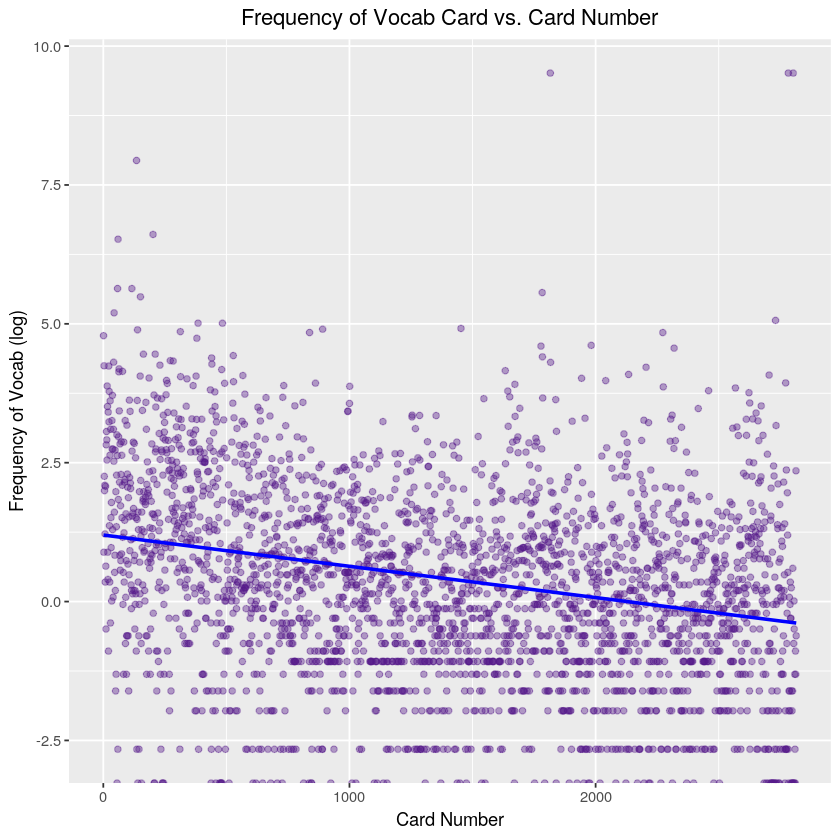

In [34]:
ggplot(data = df, aes(x = card_number, y = log(frequency))) + 
  geom_point(alpha=0.4, colour='purple4') +
  geom_smooth(method='lm', colour='blue', se=FALSE) +
  labs(title = "Frequency of Vocab Card vs. Card Number", x="Card Number", y="Frequency of Vocab (log)") +
  theme(plot.title = element_text(hjust = 0.5))

As we can see from the above scatterplot, there is a clear downward trend.

### Test

Below we casually test whether there is evidence of a negative correlation between `card_number` and `frequency` using the non-parametric [Spearman](https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient) and [Kendall](https://en.wikipedia.org/wiki/Kendall_rank_correlation_coefficient) correlation tests.

In [35]:
cor.test(df$card_number, df$frequency, method='kendall')


	Kendall's rank correlation tau

data:  df$card_number and df$frequency
z = -15.052, p-value < 2.2e-16
alternative hypothesis: true tau is not equal to 0
sample estimates:
       tau 
-0.1908729 


In [36]:
cor.test(df$card_number, df$frequency, method='spearman', exact = FALSE)


	Spearman's rank correlation rho

data:  df$card_number and df$frequency
S = 4747116593, p-value < 2.2e-16
alternative hypothesis: true rho is not equal to 0
sample estimates:
       rho 
-0.2782298 


So stated simply, there is significant evidence that the more vocabulary flashcards I make, the more rare the words on those cards become.

And thus concludes the analysis. Thanks for reading!